<a href="https://colab.research.google.com/github/AishaLichtner/projects-2019/blob/master/Block_time_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import tensorflow.compat.v1 as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,Conv1D,Conv3D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge



from tensorflow.keras import optimizers as opt
import tensorflow.keras.backend as K
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import datetime
import statistics


#get last sunday of the month
import sys
import calendar

from tensorflow.keras import layers

print(tf.__version__)

import numpy as np     # matrix structures, linear algebra functions etc
from sklearn.linear_model import LinearRegression   # linear regression model
from sklearn.metrics import mean_squared_error, mean_absolute_error   # accuracy metrics

import io


1.15.0


#Read  data from csv file


In [0]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/data/blocks.csv"
#data = pd.read_csv(io.StringIO(uploaded["blocks.csv"].decode('utf-8')))
data= pd.read_csv(path, sep = ';', encoding="utf-8-sig")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data.tail()

,Acreg,Version,Std UTC,Sta Utc,Flightcode,AOC,DP Iatacode,AR Iatacode,Rm Off Block Utc,Rm Takeoff Utc,TaxiOut,Rm Touchdown Utc,Rm On Block Utc,TaxiIn,BlkSched,ActualBlock
561264,YRBMI,737-800,30.08.2019 18:15,30.08.2019 21:55,DY4214,WET,PMI,ARN,30.08.2019 18:15,30.08.2019 18:25,10,30.08.2019 21:46,30.08.2019 21:51,5.0,220,216
561265,YRBMI,737-800,31.08.2019 06:15,31.08.2019 08:25,DY4487,WET,ARN,BUD,31.08.2019 06:15,31.08.2019 06:24,9,31.08.2019 08:24,31.08.2019 08:29,5.0,130,134
561266,YRBMI,737-800,31.08.2019 09:05,31.08.2019 11:15,DY4488,WET,BUD,ARN,31.08.2019 09:08,31.08.2019 09:28,20,31.08.2019 11:22,31.08.2019 11:28,6.0,130,140
561267,YRBMI,737-800,31.08.2019 12:05,31.08.2019 16:30,DY4223,WET,ARN,AGP,31.08.2019 12:21,31.08.2019 12:31,10,31.08.2019 16:21,31.08.2019 16:25,4.0,265,244
561268,YRBMI,737-800,31.08.2019 17:20,31.08.2019 21:30,DY4224,WET,AGP,ARN,31.08.2019 17:20,31.08.2019 17:27,7,31.08.2019 21:10,31.08.2019 21:22,12.0,250,242


In [0]:
#exclude flights that are done with other planes
data= data.loc[data['AOC'] != "WET"]
data.dropna()
data.shape


(546863, 16)

In [0]:
#just take relevant data in account and save a copy for later
data_kopiert= data.copy()

data=data[['ActualBlock', 'Std UTC', "DP Iatacode", "AR Iatacode", "BlkSched"]]
data["DiffBlock"] = abs(data["ActualBlock"]- data["BlkSched"])
data_kopiert["DiffBlock"] = abs(data["ActualBlock"]- data["BlkSched"])
data

,ActualBlock,Std UTC,DP Iatacode,AR Iatacode,BlkSched,DiffBlock
3211,406,06.05.2018 01:20,BOS,LGW,380,26
5924,168,01.06.2017 05:20,MAD,TFN,175,7
5925,173,01.06.2017 08:55,TFN,MAD,165,8
5926,250,02.06.2017 06:00,MAD,HEL,250,0
5927,289,02.06.2017 10:55,HEL,MAD,265,24
...,...,...,...,...,...,...
559169,742,25.10.2019 12:50,BCN,LAX,730,12
559170,659,26.10.2019 03:00,LAX,BCN,655,4
559171,524,26.10.2019 17:25,BCN,EWR,515,9
559172,436,27.10.2019 03:59,EWR,BCN,436,0


#Use one Hot Encoding for airport combinations


In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [0]:
toEncode =data[['DP Iatacode','AR Iatacode']]

In [0]:
toEncode.tail()

,DP Iatacode,AR Iatacode
559169,BCN,LAX
559170,LAX,BCN
559171,BCN,EWR
559172,EWR,BCN
559173,BCN,JFK


In [0]:
toEncode.shape

(546863, 2)

With one Hot encoding we higher the dimnsion of the (546863, 2)- matrix, so we have more information, that the network can use.

In [0]:
# prepare input data
def prepare_inputsOH(X):
	ohe = OneHotEncoder(sparse=False)
	X_train_enc = ohe.fit_transform(X)
	return X_train_enc

In [0]:
print(prepare_inputsOH(toEncode))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
encodedOH = prepare_inputsOH(toEncode) #returns a
encodedOH = pd.DataFrame(encodedOH)
sum(encodedOH == 1) #double check, that this did not produce a matrix full of zeros

83028

In [0]:
print(encodedOH.isna())
print(encodedOH.shape)
print(data.shape)

          0      1      2      3      4    ...    403    404    405    406    407
0       False  False  False  False  False  ...  False  False  False  False  False
1       False  False  False  False  False  ...  False  False  False  False  False
2       False  False  False  False  False  ...  False  False  False  False  False
3       False  False  False  False  False  ...  False  False  False  False  False
4       False  False  False  False  False  ...  False  False  False  False  False
...       ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
546858  False  False  False  False  False  ...  False  False  False  False  False
546859  False  False  False  False  False  ...  False  False  False  False  False
546860  False  False  False  False  False  ...  False  False  False  False  False
546861  False  False  False  False  False  ...  False  False  False  False  False
546862  False  False  False  False  False  ...  False  False  False  False  False

[546863 rows x 

In [0]:
#fix some dimension problems
data.reset_index(drop=True, inplace=True)
encodedOH.reset_index(drop=True, inplace=True)
data.head()

,ActualBlock,Std UTC,DP Iatacode,AR Iatacode,BlkSched,DiffBlock
0,406,06.05.2018 01:20,BOS,LGW,380,26
1,168,01.06.2017 05:20,MAD,TFN,175,7
2,173,01.06.2017 08:55,TFN,MAD,165,8
3,250,02.06.2017 06:00,MAD,HEL,250,0
4,289,02.06.2017 10:55,HEL,MAD,265,24


In [0]:
#delete encoded information
data.pop("DP Iatacode") 
data.pop("AR Iatacode")

0         LGW
1         TFN
2         MAD
3         HEL
4         MAD
         ... 
546858    LAX
546859    BCN
546860    EWR
546861    BCN
546862    JFK
Name: AR Iatacode, Length: 546863, dtype: object

In [0]:
#concat original data with one hot encoding matrix
data=pd.concat([data,encodedOH ],axis = 1)
print(data)

        ActualBlock           Std UTC  BlkSched  DiffBlock  ...  404  405  406  407
0               406  06.05.2018 01:20       380         26  ...  0.0  0.0  0.0  0.0
1               168  01.06.2017 05:20       175          7  ...  0.0  0.0  0.0  0.0
2               173  01.06.2017 08:55       165          8  ...  0.0  0.0  0.0  0.0
3               250  02.06.2017 06:00       250          0  ...  0.0  0.0  0.0  0.0
4               289  02.06.2017 10:55       265         24  ...  0.0  0.0  0.0  0.0
...             ...               ...       ...        ...  ...  ...  ...  ...  ...
546858          742  25.10.2019 12:50       730         12  ...  0.0  0.0  0.0  0.0
546859          659  26.10.2019 03:00       655          4  ...  0.0  0.0  0.0  0.0
546860          524  26.10.2019 17:25       515          9  ...  0.0  0.0  0.0  0.0
546861          436  27.10.2019 03:59       436          0  ...  0.0  0.0  0.0  0.0
546862          504  27.10.2019 17:05       535         31  ...  0.0  0.0  0

#Split date into day hour and weekday and season

In [0]:
#exclude date colum of flightBlock so we can split it in more information
date = data.pop("Std UTC")
date.tail()

546858    25.10.2019 12:50
546859    26.10.2019 03:00
546860    26.10.2019 17:25
546861    27.10.2019 03:59
546862    27.10.2019 17:05
Name: Std UTC, dtype: object

In [0]:
#calculate the last sunday for a given month in given year
def lastSunday(year,month):
    if len(sys.argv) > 1:
        try:
            year = int(sys.argv[-1])
        except ValueError:
            pass
 
   
    last_sunday = max(week[-1] for week in calendar.monthcalendar(year, month))
    return last_sunday

In [0]:
#gives inforamtion if a date is in summer or winter season
#returns 1 for winterseason and 0 for summer season
def getSeason(d):

    if (d.month<3 or d.month > 10):
        return 1;
    elif (d.month == 3 and d.day < lastSunday(d.year, d.month)):
        return 1;
    elif (d.month == 10 and d.day >= lastSunday(d.year, d.month)):
        return 1;
    else:
        return 0;
    

In [0]:
#create some more categories like time of the day, weekday and season
dateForm=[datetime.datetime.strptime(s,'%d.%m.%Y %H:%M') for s in date]

times= [x.hour for x in dateForm]
weekdays =[x.weekday()+1 for x in dateForm]
summer=[(getSeason(x)==0)*1 for x in dateForm]


In [0]:
data['Time'] = times
data["Weekday"] = weekdays
data["Summer"] = summer
data.tail()

,ActualBlock,BlkSched,DiffBlock,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,Time,Weekday,Summer
546858,742,730,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,5,1
546859,659,655,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,6,1
546860,524,515,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,6,1
546861,436,436,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,7,0
546862,504,535,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,7,0


#Remove the outliers

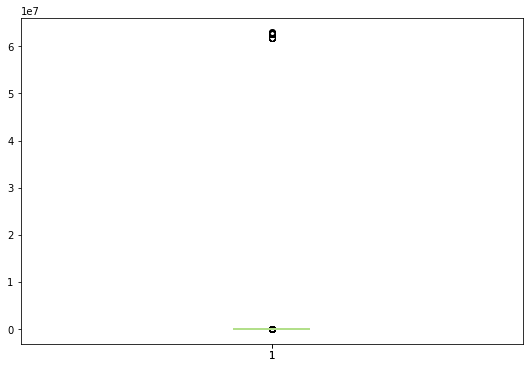

In [0]:
#Create boxplot of "ActualBlock" to see if there are outliers
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data["DiffBlock"])

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

## add patch_artist=True option to ax.boxplot() 
## to get fill color


bp = ax.boxplot(data["DiffBlock"], patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)

In [0]:
data.tail()

,ActualBlock,BlkSched,DiffBlock,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,Time,Weekday,Summer
546858,742,730,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,5,1
546859,659,655,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,6,1
546860,524,515,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,6,1
546861,436,436,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,7,0
546862,504,535,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17,7,0


In [0]:
#find the outliers
oldSize=data.shape[0]
Q1 = data["DiffBlock"].quantile(0.25)
Q3 = data["DiffBlock"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
print(Q3)
print(Q1)

#outliars beeing filtered
data = data[~((data["DiffBlock"] < (Q1 - 1.5 * IQR)) |(data["DiffBlock"] > (Q3 + 1.5 * IQR)))]
data_kopiert = data_kopiert[~((data_kopiert["DiffBlock"] < (Q1 - 1.5 * IQR)) |(data_kopiert["DiffBlock"] > (Q3 + 1.5 * IQR)))]
print("percentage of non-outlier flights:")
print(data.shape[0]/oldSize )
print(data.shape)
print(data_kopiert.shape)

8.0
11.0
3.0
percentage of non-outlier flights:
0.9437738519519514
(516115, 414)
(516115, 17)


# Build some models

In [0]:
def build_model_simple():
    model = Sequential()
    model.add(Dense(12, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
def build_model_deeper():
    model = Sequential()
    model.add(Dense(5, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(12, activation='relu',kernel_initializer='normal'))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    model.add(Dense(5, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
def build_model_wider():
    model = Sequential()
    model.add(Dense(600, activation='relu',kernel_initializer='normal', input_shape=[len(train_X.keys())]))
    model.add(Dense(65, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

In [0]:
#build a simple model with a linear layer of dimension 70 to perform PCA for 15 principal components to show later that it has the same effect as PCA
def build_pca_model():
    model = Sequential()
    model.add(Dense(70,kernel_initializer='normal', input_shape=[len(principalComponents_train.keys())])) # 70 principal components
    model.add(Dense(12, activation='relu',kernel_initializer='normal'))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model


In [0]:
def build_model_simple_pca():
    model = Sequential()
    model.add(Dense(12, activation='relu',kernel_initializer='normal', input_shape=[len(principalComponents_train.keys())]))
    model.add(Dense(10, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,kernel_initializer='normal'))
    model.compile(loss='mse',
                optimizer="adam",
                metrics=['mae', 'mse'])
    
    return model

# Build an evaluation function that tests on time predictions

In [0]:

def testModel( predict, label,mod):
   # print("This is evaluation of model on NOT clean test data for model " + stringArq)
    
    showScatter(predict,label) #displays a scatter plot of predictions and actual values for test data
    showPredictions(predict, label) #displays a table with predictions and actual values for test data
    showError(predict, label)
    onTime(predict,label)
    notLate(predict,label)


In [0]:
def showScatter(predict, label):
    plt.scatter(label, predict)
    plt.xlabel('True Values [ActualBlock]')
    plt.ylabel('Predictions [ActualBlock]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-300, 300], [-300, 300])
    plt.show()

In [0]:
def showError(predict, label):
    error =  label-predict
    plt.hist(error, bins = 25)

    plt.xlabel("Prediction Error [ActualBlock]")
    _ = plt.ylabel("Count")

    plt.xlim([-100,100])
    plt.axvline(x=-10, color="red")
    plt.axvline(x=10, color = "red")
    plt.ylim([0,plt.ylim()[1]])
    plt.show()

    print("this is the median of error, negative indicates too long, positive too short")
    print(statistics.median(error))
    print("this is the average error, negative indicates too long, positive too short")
    print(abs(error).sum()/len(error))


In [0]:
def showPredictions(predict,label):
    tabel =pd.DataFrame()
    tabel["Test Predictions"] =predict
    tabel["Test ActualBlock"] =label
    print("These are the actual Block times and their predictions")
    tabel.tail()

In [0]:
#check how many of the flights are NOT on time (+- 10 minutes)

def onTime(predict, label):
    delay = (abs(label-predict) > 10)*1
    print("this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:")
    print(sum(delay) / len(delay))


In [0]:
#check how many of the flights are more than 10 minutes late

def notLate(predict, label):
    delay = ((label-predict) > 10)*1
    print("this is the percentage of blocktimes whos predictions exceed by more than + 10 minutes:")
    print(sum(delay) / len(delay))


# Split and center data

Splitting the data 

In [0]:
#splitting data into trianing and test set still including the labels!

train_X = data.sample(frac=0.8,random_state=0)
test_X = data.drop(train_X.index)
train_labels = train_X.pop("ActualBlock")
test_labels =test_X.pop("ActualBlock")
test_labels.tail()

546839    517
546840    502
546841    433
546857    659
546859    659
Name: ActualBlock, dtype: int64

#Center the data first:


In [0]:
#center data using RobustScaler
transformer = RobustScaler().fit(train_X) 
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)
train_X= transformer.transform(train_X)
test_X = transformer.transform(test_X)


#make it a pandas dataframe again
train_X = pd.DataFrame(train_X)
test_X=pd.DataFrame(test_X)

#Do PCA on training  and test data

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=70)
principalComponents_train = pd.DataFrame(pca.fit_transform(train_X))
principalComponents_test = pd.DataFrame(pca.transform(test_X))

#Training phase

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement Early stopp muss unten als variable in callbacks eingefùegt werden
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [0]:
#dont know if that works, so I wont use it
def saveIt(model,  path2="my_model.h5"):
    path1 = "training_1/cp/.ckpt",
    #where the weights are stored
    checkpoint_path = path1
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    
    # Save the entire model to a HDF5 file.
    # The '.h5' extension indicates that the model shuold be saved to HDF5.
    model.save(path2) 

In [0]:
def trainMyModel(model,X,Y):

    history = model.fit(X.values, Y.values, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop,PrintDot()],batch_size=25)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    print("Training loss and mean square error")
    print(hist.tail())
    plot_history(history)

In [0]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
          label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

In [0]:
#create the models
modSimple = build_model_simple()
modDeep = build_model_deeper()
modWider = build_model_wider()
modPCA = build_pca_model()
modSimplePCA= build_model_simple_pca()




This is a simple Network

..........................Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
21  60.903769             5.549831  ...               60.783424     21
22  60.880610             5.544992  ...               61.462734     22
23  60.905308             5.548147  ...               61.103992     23
24  60.874412             5.542908  ...               62.137753     24
25  60.826617             5.542892  ...               62.026691     25

[5 rows x 7 columns]


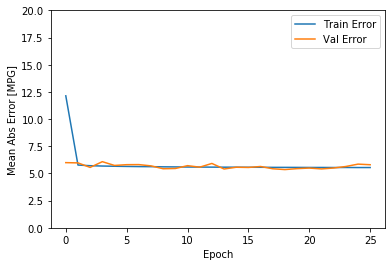

In [0]:
print("This is a simple Network")
trainMyModel(modSimple,train_X, train_labels)
#saveIt(modSimple, "modSimple.ckpt")
modSimple.save("modSimple.h5")

This is a deeper Network

...........Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
6   63.319321             5.707225  ...               62.993050      6
7   63.284907             5.702951  ...               63.109356      7
8   63.136960             5.698265  ...               62.523869      8
9   63.021737             5.689871  ...               62.500824      9
10  63.093331             5.692406  ...               66.840019     10

[5 rows x 7 columns]


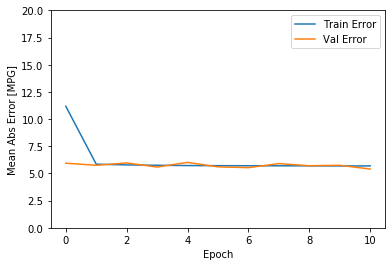

In [0]:
print("This is a deeper Network")
trainMyModel(modDeep,train_X, train_labels)
#saveIt(modDeep, "modDeep.ckpt")
modDeep.save("modDeep.h5")

This is a wider Network

.....................Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
16  53.684050             5.012355  ...               55.343021     16
17  53.334346             4.992543  ...               55.004608     17
18  53.185657             4.981677  ...               58.895935     18
19  53.005209             4.973621  ...               54.348022     19
20  52.701190             4.956374  ...               54.218113     20

[5 rows x 7 columns]


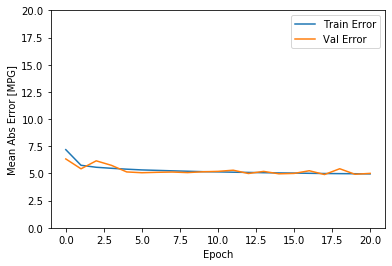

In [0]:
print("This is a wider Network")
trainMyModel(modWider,train_X, train_labels)
#saveIt(modWider, "modWider.ckpt")
modWider.save("modWider.h5")

# Observe PCA model 

We are observing the model with a linear first hidden layer, of dimension 70, that is supposed to have the same effect as performing PCA for 70 principal components and than apply the simple model to it.

This is PCA Network, on centered data

.................Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
12  66.286332             5.882587  ...               65.004395     12
13  66.140934             5.881386  ...               64.838127     13
14  66.135480             5.876434  ...               66.089134     14
15  66.087381             5.872535  ...               75.755379     15
16  66.085777             5.874361  ...               65.143669     16

[5 rows x 7 columns]


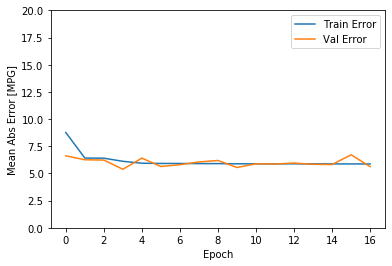

In [0]:
print("This is PCA Network, on centered data")
trainMyModel(modPCA,principalComponents_train, train_labels)


This is simple Network, on data, that has been transformed with PCA

..............Training loss and mean square error
         loss  mean_absolute_error  ...  val_mean_squared_error  epoch
9   61.576189             5.560499  ...               61.325920      9
10  61.484943             5.558392  ...               60.871849     10
11  61.429780             5.550623  ...               60.929153     11
12  61.362384             5.546337  ...               61.095490     12
13  61.291385             5.545840  ...               61.585075     13

[5 rows x 7 columns]


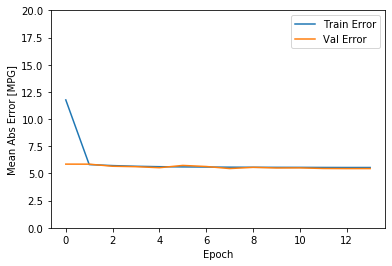

In [0]:
print("This is simple Network, on data, that has been transformed with PCA")
trainMyModel(modSimplePCA,principalComponents_train, train_labels)

#  Evaluate models on test data

This is a simple Network


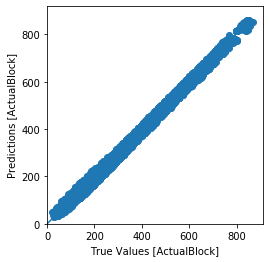

These are the actual Block times and their predictions


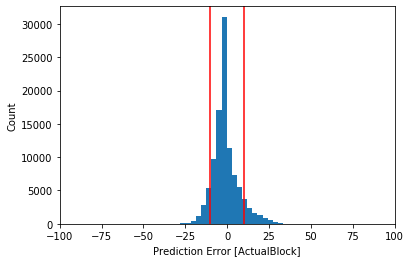

this is the median of error, negative indicates too long, positive too short
-1.8523292541503906
this is the average error, negative indicates too long, positive too short
5.800365460064143
this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:
0.17705356364376157
this is the percentage of blocktimes whos predictions exceed by more than + 10 minutes:
0.09023182817782859


In [0]:
print("This is a simple Network")
testModel(modSimple.predict(test_X).flatten(),test_labels,modSimple)


This is a deeper Network


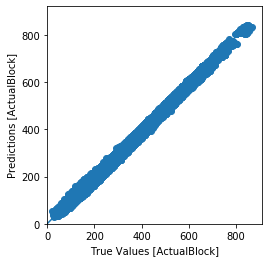

These are the actual Block times and their predictions


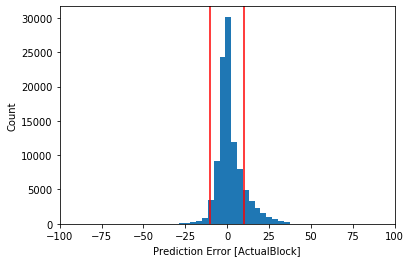

this is the median of error, negative indicates too long, positive too short
0.1387939453125
this is the average error, negative indicates too long, positive too short
5.4106993806379124
this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:
0.1583755558354243
this is the percentage of blocktimes whos predictions exceed by more than + 10 minutes:
0.13239297443399242


In [0]:
print("This is a deeper Network")
testModel(modDeep.predict(test_X).flatten(),test_labels,modDeep)


This is a wider Network


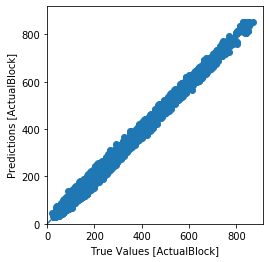

These are the actual Block times and their predictions


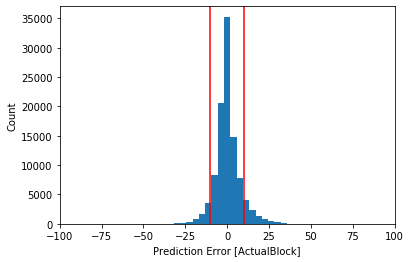

this is the median of error, negative indicates too long, positive too short
-0.3882293701171875
this is the average error, negative indicates too long, positive too short
5.017388850651752
this is the percentage of blocktimes whos predictions differmore than +/- 10 minutes from actual block times:
0.1412185268786995
this is the percentage of blocktimes whos predictions exceed by more than + 10 minutes:
0.0859304612344148


In [0]:
print("This is a wider Network")
testModel(modWider.predict(test_X).flatten(),test_labels,modWider)
